<a href="https://colab.research.google.com/github/Muzammillcoste/Crypto-currency-coin-predictor-/blob/master/Testing_Pipeline_Temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import pickle
from tensorflow.keras.models import load_model

In [ ]:
from tensorflow.keras.models import load_model
import tensorflow.keras.losses

# custom_objects = {"mse": tensorflow.keras.losses.MeanSquaredError()}

model = load_model('Final_Temp_Prediction_Model.h5')

TypeError: Error when deserializing class 'InputLayer' using config={'batch_shape': [None, 168, 11], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}.

Exception encountered: Unrecognized keyword arguments: ['batch_shape']

In [ ]:
with open('/content/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

In [ ]:
import numpy as np
import pandas as pd

def generate_dummy_data():
    date_rng = pd.date_range(start="2025-03-01", periods=168, freq="H")

    day_hours = date_rng.hour
    base_temp = 80 + 10 * np.sin(2 * np.pi * day_hours / 24)  # Daily cycle

    weekly_trend = 2 * np.sin(2 * np.pi * date_rng.dayofweek / 7)

    rush_hour_boost = np.where((7 <= day_hours) & (day_hours <= 9) | (17 <= day_hours) & (day_hours <= 19), 2, 0)

    np.random.seed(42)
    noise = np.random.normal(0, 1.5, 168)

    engine_temp = base_temp + weekly_trend + rush_hour_boost + noise

    df = pd.DataFrame({"datetime": date_rng, "Engine_Temperature": engine_temp})

    return df

In [ ]:
df_new = generate_dummy_data()
df_new.head()

<ipython-input-20-6fa9db0ab844>:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_rng = pd.date_range(start="2025-03-01", periods=168, freq="H")


,datetime,Engine_Temperature
0,2025-03-01 00:00:00,78.795215
1,2025-03-01 01:00:00,80.430938
2,2025-03-01 02:00:00,84.021677
3,2025-03-01 03:00:00,87.405757
4,2025-03-01 04:00:00,86.359168


In [ ]:
df_new.describe()

,datetime,Engine_Temperature
count,168,168.000000
mean,2025-03-04 11:30:00,80.441331
min,2025-03-01 00:00:00,67.558300
25%,2025-03-02 17:45:00,73.336581
50%,2025-03-04 11:30:00,79.829302
75%,2025-03-06 05:15:00,87.561551
max,2025-03-07 23:00:00,93.812709
std,NaN,7.388730


In [ ]:
# Load new dataset (make sure it has at least 168 hours of data)
df_new['datetime'] = pd.to_datetime(df_new['datetime'])
df_new.set_index('datetime', inplace=True)

In [ ]:
# Feature Engineering
def create_features(df):
    df["Hour"] = df.index.hour
    df["DayOfWeek"] = df.index.dayofweek
    df["Month"] = df.index.month
    df["isWeekend"] = df["DayOfWeek"].apply(lambda x: 1 if x >= 5 else 0)
    df["isRushHour"] = df["Hour"].apply(lambda x: 1 if 7 <= x <= 9 or 17 <= x <= 19 else 0)

    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * (df['Month'] - 1) / 12)
    df['month_cos'] = np.cos(2 * np.pi * (df['Month'] - 1) / 12)

    # Lag features
    df['temp_lag_24h'] = df['Engine_Temperature'].shift(24)
    df['temp_rolling_avg_3d'] = df['Engine_Temperature'].rolling(window=72).mean()

    df.drop(['Hour', 'DayOfWeek', 'Month'], axis=1, inplace=True)
    df.dropna(inplace=True)
    return df

In [ ]:
df_new = create_features(df_new)

# Select last 168 hours for prediction
features = ['Engine_Temperature', 'isWeekend', 'isRushHour',
            'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
            'month_sin', 'month_cos', 'temp_lag_24h',
            'temp_rolling_avg_3d']

In [ ]:
latest_data = df_new[features].iloc[-168:]  # Last 168 hours

In [ ]:
# Scale data using saved scaler
latest_scaled = scaler.transform(latest_data)
latest_scaled = np.expand_dims(latest_scaled, axis=0)  # Reshape for LSTM

In [ ]:
# Predict next 24 hours
predictions_scaled = model.predict(latest_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


In [ ]:
# Function to inverse scale predictions
def inverse_scale_predictions(scaled_predictions, scaler, feature_index=0):
    n_samples, n_steps = scaled_predictions.shape
    dummy = np.zeros((n_samples * n_steps, len(features)))
    dummy[:, feature_index] = scaled_predictions.flatten()

    inverse_scaled = scaler.inverse_transform(dummy)

    return inverse_scaled[:, feature_index].reshape(n_samples, n_steps)

In [ ]:
# Convert predictions back to original temperature scale
predictions = inverse_scale_predictions(predictions_scaled, scaler)

In [ ]:
# Generate timestamps for the next 24 hours
future_timestamps = pd.date_range(start=df_new.index[-1], periods=25, freq='H')[1:]

<ipython-input-31-387e94803d43>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_timestamps = pd.date_range(start=df_new.index[-1], periods=25, freq='H')[1:]


In [ ]:
# Create DataFrame with timestamps and predicted values
predictions_df = pd.DataFrame({'datetime': future_timestamps, 'Predicted_Engine_Temperature': predictions.flatten()})

print(predictions_df)

              datetime  Predicted_Engine_Temperature
0  2025-03-08 00:00:00                     91.418907
1  2025-03-08 01:00:00                     91.797157
2  2025-03-08 02:00:00                     91.058405
3  2025-03-08 03:00:00                     92.075831
4  2025-03-08 04:00:00                     90.729258
5  2025-03-08 05:00:00                     88.554353
6  2025-03-08 06:00:00                     86.436590
7  2025-03-08 07:00:00                     84.750589
8  2025-03-08 08:00:00                     81.969901
9  2025-03-08 09:00:00                     77.624384
10 2025-03-08 10:00:00                     75.164896
11 2025-03-08 11:00:00                     73.684337
12 2025-03-08 12:00:00                     72.530893
13 2025-03-08 13:00:00                     69.837621
14 2025-03-08 14:00:00                     70.790301
15 2025-03-08 15:00:00                     70.226385
16 2025-03-08 16:00:00                     70.715384
17 2025-03-08 17:00:00                     71.

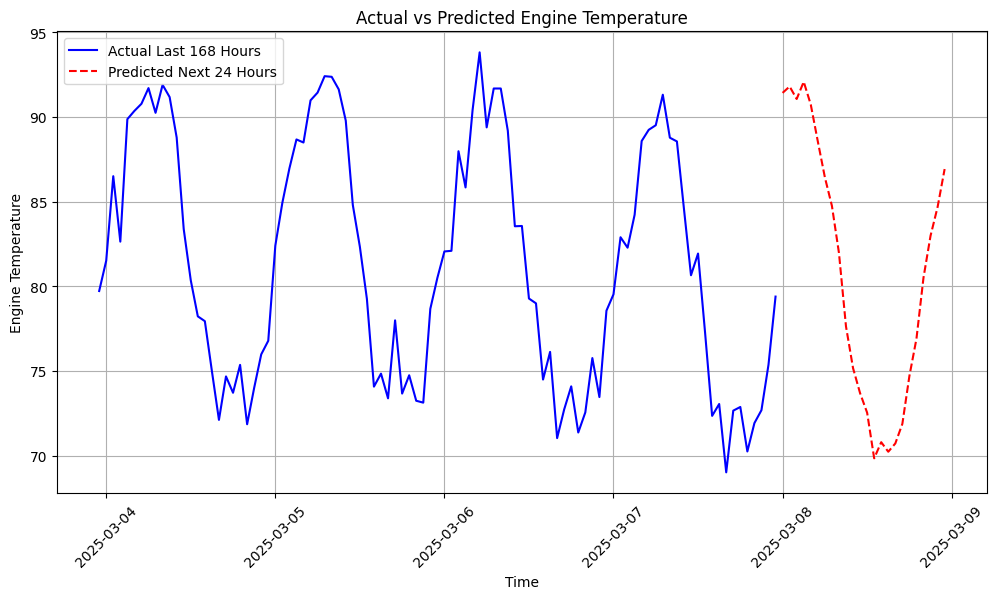

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df_new.index[-168:], df_new['Engine_Temperature'].iloc[-168:], label="Actual Last 168 Hours", color="blue")
plt.plot(predictions_df['datetime'], predictions_df['Predicted_Engine_Temperature'], label="Predicted Next 24 Hours", color="red", linestyle='dashed')
plt.xlabel("Time")
plt.ylabel("Engine Temperature")
plt.title("Actual vs Predicted Engine Temperature")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()